# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test_output = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    #y_test_output = 1 - dataset.kdd_test_2labels_y 
    
    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test_output.values

    x_train_all = x_train #[y_output.is_Normal == 1]
    y_train_all = 1 - np.argmax(y_output.values, axis = 1) # Inverting because here H0 = Normal and H1 is Attack. 
    #y_output.is_Normal.values #[y_output.is_Normal == 1]
    
    x_test_all = x_test
    y_test_all = 1- np.argmax(y_test_output.values, axis = 1) # Inverting because here H0 = Normal and H1 is Attack.
    
preprocess.x_train_all.shape

(125973, 122)

Data Reduction by:

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 1
    hidden_dim = 122
    

In [8]:
class discriminator(network):
    
    def __init__(self, hidden_layers, f):
        

        tf.reset_default_graph()
        input_dim = self.input_dim
        classes = self.classes
        hidden_dim = self.hidden_dim #f

        self.x_real = tf.placeholder("float", shape=[None, input_dim])
        self.y_real_ = tf.placeholder("float", shape=[None, classes])
        self.y_ = tf.placeholder("float", shape=[None, classes])

        self.x_random = tf.placeholder("float", shape=[None, input_dim])
        self.y_fake_ = tf.placeholder("float", shape=[None, classes])

        self.keep_prob = tf.placeholder("float")
        self.learning_rate = tf.placeholder("float")

        def discriminator_network(x, reuse=False):
            with tf.variable_scope("discriminator", reuse=reuse):
                hidden = tf.layers.dense(x, hidden_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden = tf.nn.dropout(hidden, self.keep_prob)

                for h in range(hidden_layers - 1):
                    hidden = tf.layers.dense(hidden, hidden_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                    hidden = tf.nn.dropout(hidden, self.keep_prob)

            y = tf.layers.dense(hidden, classes, activation=tf.nn.sigmoid)
            return y
        
        def generator_network(x, reuse=False):
            with tf.variable_scope('generator', reuse=reuse):
                hidden = tf.layers.dense(x, hidden_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden = tf.nn.dropout(hidden, self.keep_prob)

                for h in range(hidden_layers - 2):
                    hidden = tf.layers.dense(hidden, hidden_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                    hidden = tf.nn.dropout(hidden, self.keep_prob)

            y = tf.layers.dense(hidden, input_dim, activation=tf.nn.tanh)
            return y

        x_fake = generator_network(self.x_random)

        self.y = discriminator_network(self.x_real)
        y_fake = discriminator_network(x_fake, reuse=True)

        
        loss_real = tf.losses.sigmoid_cross_entropy(self.y_real_, self.y)
        loss_fake = tf.losses.sigmoid_cross_entropy(self.y_fake_, y_fake)

        self.loss = loss_real + loss_fake

        #correct_prediction = tf.equal(self.y_, self.y)
        #self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        d_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        g_optimizer = tf.train.AdamOptimizer(self.learning_rate)

        #gradients, variables = zip(*optimizer.compute_gradients(self.loss))
        #gradients = [
        #    None if gradient is None else tf.clip_by_value(gradient, -1, 1)
        #    for gradient in gradients]
        #self.train_op = optimizer.apply_gradients(zip(gradients, variables))
        self.d_train_op = d_optimizer.minimize(self.loss)
        self.g_train_op = g_optimizer.minimize(loss_fake)

        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        #self.pred = tf.argmax(self.y, axis = 1)
        #self.actual = tf.argmax(self.y_real_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()


In [9]:
class generator1(network):
    
    def __init__(self, hidden_layers):
        
        input_dim = self.input_dim
        hidden_dim = self.hidden_dim
            
        self.graph = tf.Graph()
        with self.graph.as_default():
            
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.keep_prob = tf.placeholder("float")

            self.learning_rate = tf.placeholder("float")
            self.loss = tf.placeholder("float")

            hidden = tf.layers.dense(self.x, hidden_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden = tf.nn.dropout(hidden, self.keep_prob)

            for h in range(hidden_layers - 1):
                hidden = tf.layers.dense(hidden, hidden_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden = tf.nn.dropout(hidden, self.keep_prob)

            self.y = tf.layers.dense(hidden, input_dim, activation=tf.nn.tanh)

            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            #gradients, variables = zip(*optimizer.compute_gradients(self.loss))
            #gradients = [
            #    None if gradient is None else tf.clip_by_value(gradient, -1, 1)
            #    for gradient in gradients]
            #self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            self.train_op = optimizer.minimize(hidden)

            # add Saver ops
            self.saver = tf.train.Saver()

In [10]:
import collections

class Train:    
    alpha = 0.8
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, h, f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        
        d = discriminator(h, f)
        #g = generator(h)
        
        os.makedirs("dataset/tf_GAN_with_Dense_nsl_kdd/hidden_layers_{}_features_count_{}".format(epochs,h,f),
                    exist_ok = True)
        
        d.sess = tf.Session()
        
        #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
        #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

        d.sess.run(tf.global_variables_initializer())

        for lr in lrs:
            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train_all, 
                                                                          preprocess.y_train_all, 
                                                                          test_size=0.1)
                
                x_train = x_train[y_train == 0]
                y_train = y_train[y_train == 0]
                
                y_train = np.reshape(y_train, (-1,1))
                y_train_normal = np.zeros_like(y_train)
                y_train_attack = np.ones_like(y_train)
                x_train_attack_rnd = np.random.normal(size=x_train.shape)

                y_valid = np.reshape(y_valid, (-1,1))
                y_valid_normal = np.zeros_like(y_valid)
                y_valid_attack = np.ones_like(y_valid)
                x_valid_attack_rnd = np.random.normal(size=x_valid.shape)

                y_test_all = np.reshape(preprocess.y_test_all, (-1,1))
                y_test_normal = np.zeros_like(y_test_all)
                y_test_attack = np.ones_like(y_test_all)
                x_test_attack_rnd = np.random.normal(size=preprocess.x_test_all.shape)

                batch_indices = np.array_split(np.arange(x_train.shape[0]), batch_iterations)

                for i in batch_indices:

                    def train_batch():
                        nonlocal train_loss

                        # Passing Normal (real) and Attack (fake) Traffic and training together
                        d_loss, _ = d.sess.run([d.loss, d.d_train_op], 
                                              feed_dict={d.x_real: x_train[i,:],
                                                         d.y_:y_train[i,:],
                                                         d.y_real_: y_train_normal[i,:],
                                                         d.x_random: x_train_attack_rnd[i,:],
                                                         d.y_fake_: y_train_attack[i,:],
                                                         d.keep_prob:1,
                                                         d.learning_rate:lr})

                        #Train Generator
                        #g.sess.run([g.train_op], feed_dict={g.loss:d_loss_attack_fake})

                        train_loss = d_loss

                    train_batch()
                    #summary_writer_train.add_summary(summary_str, epoch)
                    while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                        d.saver.restore(sess, 
                                          tf.train.latest_checkpoint('dataset/tf_GAN_with_Dense_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                     .format(epochs,h,f)))
                        train_batch()


                y_valid_pred = d.sess.run(d.y, #net.summary_op 
                                                      feed_dict={d.x_real: x_valid, 
                                                                 d.y_real_: y_valid_normal,
                                                                 d.y_:y_valid,
                                                                 d.x_random: x_valid_attack_rnd,
                                                                 d.y_fake_: y_valid_attack,
                                                                 d.keep_prob:1,
                                                                 d.learning_rate:lr})
                #summary_writer_valid.add_summary(summary_str, epoch)


                y_test_pred = d.sess.run(d.y, 
                                                feed_dict={d.x_real: preprocess.x_test_all, 
                                                         d.y_real_: y_test_normal,
                                                         d.y_: y_test_all,
                                                         d.x_random: x_test_attack_rnd,
                                                         d.y_fake_: y_test_attack,
                                                         d.keep_prob:1,
                                                         d.learning_rate:lr})

                def get_accuracy(y_pred, y_actual):
                    y_attack = np.logical_or(y_pred > Train.alpha, y_pred < -Train.alpha)
                    y_normal = np.logical_or(y_pred < Train.alpha, y_pred > -Train.alpha)
                    
                    pred_value = np.argmax([y_normal, y_attack], axis = 0)
                    accuracy = np.mean(np.equal(y_actual, pred_value))
                    
                    pred_value = np.squeeze(pred_value)
                    y_attack = np.squeeze(y_attack)
                    y_normal = np.squeeze(y_normal)
                    
                    return accuracy, pred_value, y_attack, y_normal
                    
                valid_accuracy, _,_,_ = get_accuracy(y_valid_pred, y_valid)
                accuracy, pred_value, y_attack, y_normal = get_accuracy(y_test_pred, y_test_all)
                
                print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                print("Accuracy on Test data: {}".format(accuracy))
                
                if accuracy > Train.best_acc:
                    
                    actual_value = y_test_normal
                    
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                                   
                    if not (np.isnan(train_loss)):
                        d.saver.save(d.sess, 
                                   "dataset/tf_GAN_with_Dense_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                    global_step = epochs)
                    curr_pred = pd.DataFrame({"Attack_prob":y_attack, "Normal_prob":y_normal, "Prediction":pred_value})
                    Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):(curr_pred, 
                                               Train.result(epochs*len(lrs), f, h,valid_accuracy, accuracy))})

                    #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [11]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [10]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        
        Train.train(e, h, f, [0.001, 0.0001])
        

Current Layer Attributes - epochs:1 hidden layers:2 features count:4
Step 1 | Training Loss: 1.006458 | Validation Accuracy: 0.532862
Accuracy on Test data: 0.43075762952448543
Step 1 | Training Loss: 1.006459 | Validation Accuracy: 0.529290
Accuracy on Test data: 0.43075762952448543
Current Layer Attributes - epochs:1 hidden layers:2 features count:8
Step 1 | Training Loss: 1.006452 | Validation Accuracy: 0.529290
Accuracy on Test data: 0.43075762952448543
Step 1 | Training Loss: 1.006450 | Validation Accuracy: 0.540324
Accuracy on Test data: 0.43075762952448543
Current Layer Attributes - epochs:1 hidden layers:2 features count:16
Step 1 | Training Loss: 1.006454 | Validation Accuracy: 0.531672
Accuracy on Test data: 0.43075762952448543
Step 1 | Training Loss: 1.006439 | Validation Accuracy: 0.540244
Accuracy on Test data: 0.43075762952448543
Current Layer Attributes - epochs:1 hidden layers:2 features count:32
Step 1 | Training Loss: 1.006455 | Validation Accuracy: 0.535799
Accuracy 

In [12]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [13]:
Train.predictions = dict1
Train.results = dict2

In [14]:
df_results = pd.DataFrame(Train.results)

In [15]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
0,2,4,2,0.532862,0.430758
1,2,8,2,0.529290,0.430758
2,2,16,2,0.531672,0.430758
3,2,32,2,0.535799,0.430758
4,2,122,2,0.536117,0.430758
5,2,4,4,0.526592,0.430758
6,2,8,4,0.537943,0.430758
7,2,16,4,0.535879,0.430758
8,2,32,4,0.534529,0.430758
9,2,122,4,0.531195,0.430758


In [16]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_GAN_with_Dense_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_GAN_with_Dense_nsl_kdd_scores.pkl")

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 1.]]


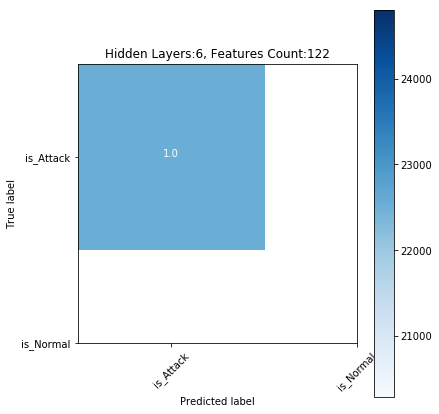

In [18]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)